<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-01-06-glm-multinomial-logistic-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6. Multinomial Logistic Regression

Multinomial Logistic Regression is an essential statistical technique for predicting categorical outcomes where the response variable has more than two classes. It’s widely used in various fields, such as healthcare, marketing, and social sciences, to model and interpret multi-class problems such as customer preferences, diagnosis predictions, and product category classification. This tutorial will guide you through the essentials of multinomial logistic regression, from building a model from scratch in R to leveraging the {nnet} package for a more efficient approach.


## Overview

Multinomial logistic regression is a statistical technique used to model the relationship between multiple independent variables and a categorical dependent variable with more than two possible outcome categories or nominal outcome variables. It is an extension of binary logistic regression, which deals with just two categories.

In multinomial logistic regression, the dependent variable can have three or more categories, and the model estimates the probability of each category given a set of predictors. The model calculates separate equations for each category relative to a reference category. These equations are typically based on the log-odds of the probability of belonging to each category. The multinomial logistic regression model assumes that the relationship between the independent variables and the dependent variable is linear in the logit (log-odds) space. The coefficients estimated by the model represent the effect of each independent variable on the log-odds of being in each category relative to the reference category.

Interpretation of the coefficients in multinomial logistic regression can be challenging because they represent the change in log-odds relative to the reference category. Therefore, converting these coefficients into odds ratios or probabilities can help in understanding the effects of the independent variables on the outcome categories.

In multinomial logistic regression, we aim to model the probability $P(Y = k | X)$ of an observation belonging to category $k$, given the predictor variables $X$.

First, let's define the parameters of the model. We have:

-   $K$ categories for the dependent variable, indexed from $k = 1$ to $k = K$.

-   $p_{ik}$ represents the probability of observation $i$ belonging to category $k$.

-   $\beta_{jk}$ represents the coefficient for predictor $j$ in predicting category $k$.

Now, let's define the linear predictor for each category $k$:

$$ \text{Linear predictor for category } k: \quad \eta_{ik} = \beta_{0k} + \beta_{1k}x_{i1} + \beta_{2k}x_{i2} + \ldots + \beta_{pk}x_{ip} $$

Where:

-   $\eta_{ik}$ is the linear predictor for observation $i$ and category $k$.

-   $\beta_{0k}$ is the intercept for category $k$.

-   $\beta_{jk}$ are the coefficients for predictor $j$ and category $k$.

-   $x_{ij}$ are the values of the predictor variables for observation $i$.

Next, we transform the linear predictor into probabilities using the softmax function. The softmax function ensures that the predicted probabilities sum to 1 across all categories:

$$ P(Y = k | X) = \frac{e^{\eta_{ik}}}{\sum_{j=1}^{K} e^{\eta_{ij}}} $$

Where:

-   $e$ is Euler's number (approximately 2.71828).

-   $\eta_{ik}$ is the linear predictor for observation $i$ and category $k$.

The parameters $\beta_{jk}$ are estimated using maximum likelihood estimation, where the goal is to maximize the likelihood function:

$$ L(\beta) = \prod_{i=1}^{n} \prod_{k=1}^{K} P(Y_i = k | X_i)^{I(Y_i = k)} $$

Where:

-   $n$ is the number of observations.

-   $I(\cdot)$ is an indicator function that equals 1 if the condition is true and 0 otherwise.

-   $Y_i$ is the observed category for observation $i$.

The coefficients $\beta_{jk}$ are typically estimated using optimization algorithms such as gradient descent or Newton-Raphson to find the values that maximize the likelihood function.

Once the coefficients are estimated, predictions for new observations can be made by plugging the predictor values into the model and applying the softmax function to obtain the probabilities for each category.


## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314953 sha256=e5ddcd6b0fa0fdb706f79ec3f8e938f7de8a93da987b9564e5476072c1c40a21
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Miltinomial Logistic Regression

To create a multinomial logistic regression from scratch in R, we’ll build a model that handles a response variable with three levels (e.g., categories A, B, and C), using four continuous predictors and one categorical predictor with two levels (Male and Female). Here’s a step-by-step approach:

### Simulate data

In [4]:
%%R
set.seed(123)  # For reproducibility

# Create synthetic dataset
n <- 300  # Number of observations
data <- data.frame(
  response = factor(sample(c("Level1", "Level2", "Level3"), n, replace = TRUE)),
  continuous1 = rnorm(n),
  continuous2 = rnorm(n),
  continuous3 = rnorm(n),
  continuous4 = rnorm(n),
  gender = factor(sample(c("Male", "Female"), n, replace = TRUE))
)

# Convert response to a factor and set reference level
data$response <- relevel(data$response, ref = "Level1")
head(data)

  response continuous1 continuous2 continuous3 continuous4 gender
1   Level3   1.9009001  -0.2043353 -0.00497512  0.81293718   Male
2   Level3   0.7089544   0.5583362 -1.38088679  0.41497661 Female
3   Level3   0.7361948   0.3242106 -1.25652688 -0.08585906   Male
4   Level2   1.3657766   0.6977370  0.32524572 -1.90820891   Male
5   Level3  -0.5762639  -1.0225731 -0.27700053  0.66325198   Male
6   Level2  -0.8047323  -0.1682708 -0.38901100  0.66168573   Male


### Data Preparation

In [5]:
%%R
# Data Preparation
# Encode categorical variables (using "Level1" as the baseline for response)
response_matrix <- model.matrix(~ response - 1, data = data)
gender_matrix <- model.matrix(~ gender - 1, data = data)

# Check dimensions of response_matrix and gender_matrix
print(dim(response_matrix))  # Expected: n x 3 (for three levels of response)
print(dim(gender_matrix))    # Expected: n x 2 (for two levels of gender, one baseline)

[1] 300   3
[1] 300   2


### Define Log-Likelihood Function

The log-likelihood function is a fundamental concept in statistics, particularly in maximum likelihood estimation (MLE). It measures how well a statistical model explains a set of observations, and it's central to estimating the parameters of a model that are most likely to have produced the observed data.

In [6]:
%%R
# Define Log-Likelihood Function
log_likelihood <- function(params, response_matrix, X) {
  # Reshape params into a matrix with dimensions for each predictor and response level
  beta <- matrix(params, ncol = 2, byrow = TRUE)
  eta <- X %*% beta
  p <- exp(eta) / (1 + rowSums(exp(eta)))

  # Add a baseline category (1 - rowSums(p)) for Level1 as reference
  p <- cbind(1 - rowSums(p), p)

  # Negative log-likelihood calculation
  ll <- -sum(response_matrix * log(p))
  return(ll)
}

### Combine Predictors

In [7]:
%%R
# Combine Predictors
X <- cbind(1, X1=data$x1, X2=data$x2, X3=data$x3, X4=data$x4, Gender=gender_matrix[, 2])

### Optimization for MLE

The `optim()` function in R is a general-purpose optimization function often used to find the values of parameters that maximize (or minimize) a function. In the context of maximum likelihood estimation (MLE), `optim()` is typically used to maximize the log-likelihood function and find the parameter estimates that best explain the observed data.

In [8]:
%%R
# Optimization for MLE
# Initialize parameters
initial_params <- rep(0, ncol(X) * 2)  # Adjust for two response levels (Level2 and Level3)
fit <- optim(initial_params, log_likelihood, response_matrix = response_matrix, X = X, method = "BFGS", hessian = TRUE)

###  Summary  of the Model

In [9]:
%%R
# Extract coefficients and reshape
coefficients <- matrix(fit$par, ncol = 2, byrow = TRUE)
colnames(coefficients) <- c("Level2", "Level3")
rownames(coefficients) <- colnames(X)  # Ensure row names are correctly set

#Compute Standard Errors and Z-Statistics
# Invert Hessian to get variance-covariance matrix, then take the square root of diagonal for SEs
standard_errors <- sqrt(diag(solve(fit$hessian)))

# Compute z-statistics
z_stats <- coefficients / matrix(standard_errors, ncol = 2, byrow = TRUE)

summary_table <- data.frame(
  Predictor = rep(rownames(coefficients), each = ncol(coefficients)),
  Level = rep(colnames(coefficients), times = nrow(coefficients)),
  Coefficient = as.vector(coefficients),
  Std_Error = standard_errors,
  Z_Statistic = as.vector(z_stats)
  )
# Display summary table
print(summary_table)

  Predictor  Level Coefficient Std_Error Z_Statistic
1           Level2 -0.09097131 0.2134213  -0.4262522
2           Level3 -0.07333172 0.2074024  -0.2616366
3    Gender Level2  0.02150648 0.2802808   0.1036945
4    Gender Level3 -0.44996116 0.2853473  -1.5768896


### Relative Risk Ratios (RRRs)

In the context of multinomial logistic regression, the concept of relative risk ratios (RRRs) can be interpreted similarly to odds ratios in binary logistic regression. RRRs quantify the relative change in the odds of being in one category compared to a reference category, for a one-unit change in the predictor variable.

To obtain the relative risk ratios, you exponentiate the coefficients:

$$ \text{RRR}{j, k} = e^{\beta{jk}} $$

Where: - $\text{RRR}{j, k}$ is the relative risk ratio for predictor $j$ and category $k$,

-   $\beta{jk}$ is the coefficient for predictor $j$ and category $k$ ).

These relative risk ratios quantify how much the odds of being in category $k$ change for a one-unit increase in the predictor variable $X_j$, relative to the reference category. You can interpret a relative risk ratio of 1 as indicating no change in the odds of being in category $k$ for a one-unit change in the predictor variable. A relative risk ratio greater than 1 indicates an increase in the odds, while a ratio less than 1 indicates a decrease in the odds.

We can extract the coefficients from the model object and exponentiate them to obtain the relative risk ratios. This will give you the relative risk ratios for each predictor variable and each category of the dependent variable in the multinomial logistic regression model.

In [10]:
%%R
rrr <- exp(coefficients)
risk_table <- data.frame(
  Predictor = rep(rownames(coefficients), each = ncol(coefficients)),
  Level = rep(colnames(coefficients), times = nrow(coefficients)),
  RRR = as.vector(rrr)
)
print(risk_table)

  Predictor  Level       RRR
1           Level2 0.9130439
2           Level3 0.9292925
3    Gender Level2 1.0217394
4    Gender Level3 0.6376529



## Multinominal Logistic Regression in R

Multinomial Logistic Regression in R can be implemented using the `multinom()` function from the {nnet} package. This function allows us to fit a logistic regression model when the outcome variable has more than two categories.

### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse',
     'plyr',
		 'gt',
		 'rstatix',
		 'gtsummary',
		 'DataExplorer',
		 'report',
		 'performance',
		 'jtools',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'RColorBrewer',
		 'MASS',
     'generalhoslem',
		 'nnent'
		 )
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages(c("gmp", "Rmpfr", "PMCMRplus",'hrbrthemes'), lib='drive/My Drive/R/')
install.packages("ggstatsplot", lib='drive/My Drive/R/')

### Load packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(plyr)
library(gt)
library(rstatix)
library(gtsummary)
library(DataExplorer)
library(report)
library(performance)
library(jtools)
library(margins)
library(marginaleffects)
library(ggeffects)
library(patchwork)
library(Metrics)
library(ggpmisc)
#library(metrica)
library(RColorBrewer)
library(MASS)
library(generalhoslem)
library(kableExtra)
library(nnet)

### Data

In this tutorial, we will be using [health_insurance data](http://peopleanalytics-regression-book.org/data/health_insurance.csv).

The health_insurance data set consists of the following fields:

* `product`: The choice of product of the individual—A, B or C
* `age`: The age of the individual when they made the choice
* `gender`: The gender of the individual as stated when they made the choice
* `household`: The number of people living with the individual in the same household at the time of the choice
* `position_level`: Position level in the company at the time they made the choice, where 1 is is the lowest and 5 is the highest
* `absent`: The number of days the individual was absent from work in the year prior to the choice

Full data set is available for download can download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.

We will use `read_csv()` function of **readr** package to import data as a **tidy** data.

In [12]:
%%R
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/health_insurance.csv") |>
  glimpse()

Rows: 1448 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): product, gender
dbl (4): age, household, position_level, absent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1,448
Columns: 6
$ product        <chr> "C", "A", "C", "A", "A", "A", "A", "B", "C", "B", "B", …
$ age            <dbl> 57, 21, 66, 36, 23, 31, 37, 37, 55, 66, 58, 62, 31, 45,…
$ household      <dbl> 2, 7, 7, 4, 0, 5, 3, 0, 3, 2, 1, 2, 2, 5, 3, 5, 4, 7, 7…
$ position_level <dbl> 2, 2, 2, 2, 2, 1, 3, 3, 3, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4…
$ gender         <chr> "Male", "Male", "Male", "Female", "Male", "Male", "Male…
$ absent         <dbl> 10, 7, 1, 6, 11, 14, 12, 25, 3, 18, 1, 25, 0, 10, 20, 2…


#### Convert to Factor



In [13]:
%%R
mf$product <- as.factor(mf$product)
mf$gender <- as.factor(mf$gender)

#### Summary Statistics


In [14]:
%%R
mf |>
  # select variables
  dplyr::select (age,  household,
                position_level,
                absent,
                gender) |>
  get_summary_stats (type = "common")

# A tibble: 4 × 10
  variable           n   min   max median   iqr  mean    sd    se    ci
  <fct>          <dbl> <dbl> <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 age             1448    21    67     37    23 40.9  13.5  0.356 0.698
2 household       1448     0     7      3     3  3.26  2.23 0.059 0.115
3 position_level  1448     1     5      3     2  2.90  1.22 0.032 0.063
4 absent          1448     0    31     15    13 14.5   8.11 0.213 0.418


#### Box/Violine Plots

We can create a nice looking plots with results of ANOVA and post-hoc tests on the same plot (directly on the boxplots). We will use `gbetweenstats()` function of **ggstatsplot** package:

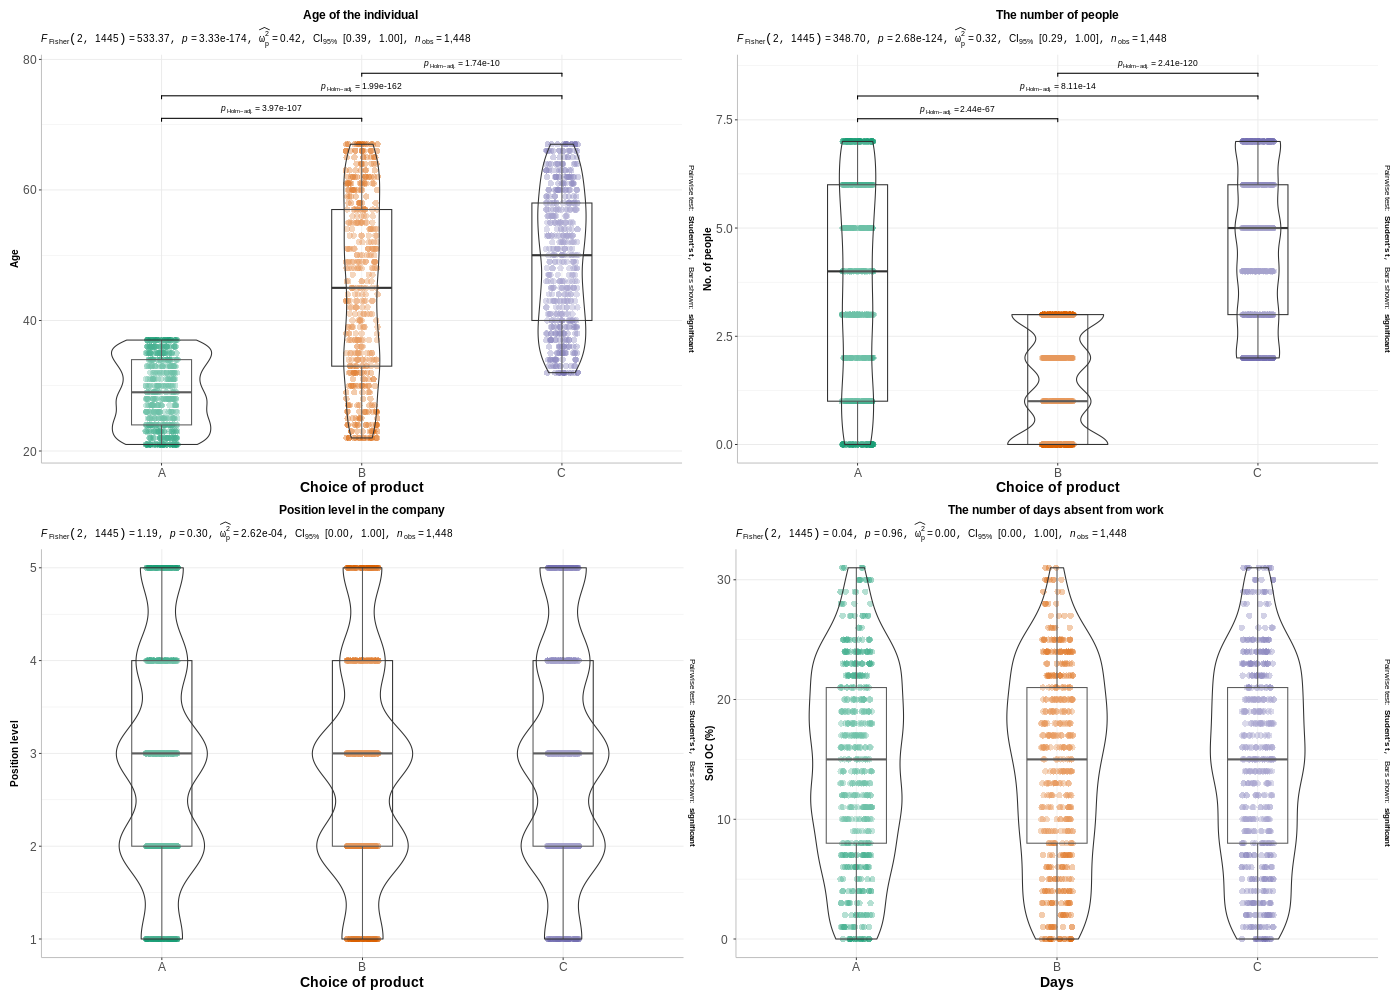

In [15]:
%%R -w 1400 -h 1000 -u px
p1<-ggstatsplot::ggbetweenstats(
  data = mf,
  x = product,
  y = age,
  ylab = "Age",
  xlab = "Choice of product",
  type = "parametric", # ANOVA or Kruskal-Wallis
  var.equal = TRUE, # ANOVA or Welch ANOVA
  plot.type = "box",
  pairwise.comparisons = TRUE,
  pairwise.display = "significant",
  centrality.plotting = FALSE,
  bf.message = FALSE
)+
# add plot title
ggtitle("Age of the individual ") +
   theme(
    # center the plot title
    plot.title = element_text(hjust = 0.5),
    axis.line = element_line(colour = "gray"),
    # axis title font size
    axis.title.x = element_text(size = 14),
    # X and  axis font size
    axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5),
    axis.text.x = element_text(size=12))

p2<-ggstatsplot::ggbetweenstats(
  data = mf,
  x = product,
  y = household,
  ylab = "No. of people",
  xlab = "Choice of product",
  type = "parametric", # ANOVA or Kruskal-Wallis
  var.equal = TRUE, # ANOVA or Welch ANOVA
  plot.type = "box",
  pairwise.comparisons = TRUE,
  pairwise.display = "significant",
  centrality.plotting = FALSE,
  bf.message = FALSE
)+
# add plot title
ggtitle("The number of people") +
   theme(
    # center the plot title
    plot.title = element_text(hjust = 0.5),
    axis.line = element_line(colour = "gray"),
    # axis title font size
    axis.title.x = element_text(size = 14),
    # X and  axis font size
    axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5),
    axis.text.x = element_text(size=12))

p3<-ggstatsplot::ggbetweenstats(
  data = mf,
  x = product,
  y = position_level,
  ylab = "Position level",
  xlab = "Choice of product",
  type = "parametric", # ANOVA or Kruskal-Wallis
  var.equal = TRUE, # ANOVA or Welch ANOVA
  plot.type = "box",
  pairwise.comparisons = TRUE,
  pairwise.display = "significant",
  centrality.plotting = FALSE,
  bf.message = FALSE
)+
# add plot title
ggtitle("Position level in the company") +
   theme(
    # center the plot title
    plot.title = element_text(hjust = 0.5),
    axis.line = element_line(colour = "gray"),
    # axis title font size
    axis.title.x = element_text(size = 14),
    # X and  axis font size
    axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5),
    axis.text.x = element_text(size=12))


p4<-ggstatsplot::ggbetweenstats(
  data = mf,
  x = product,
  y = absent,
  ylab = "Soil OC (%)",
  xlab = "Days",
  type = "parametric", # ANOVA or Kruskal-Wallis
  var.equal = TRUE, # ANOVA or Welch ANOVA
  plot.type = "box",
  pairwise.comparisons = TRUE,
  pairwise.display = "significant",
  centrality.plotting = FALSE,
  bf.message = FALSE
)+
# add plot title
ggtitle("The number of days absent from work ") +
   theme(
    # center the plot title
    plot.title = element_text(hjust = 0.5),
    axis.line = element_line(colour = "gray"),
    # axis title font size
    axis.title.x = element_text(size = 14),
    # X and  axis font size
    axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5),
    axis.text.x = element_text(size=12))

   (p1|p2)/(p3|p4)

#### Split Data

In [17]:
%%R
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= ddply(mf,.(product, gender ),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(mf, .(product , gender),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
print(prop.table(table(train$product)))
print(prop.table(table(test$product)))


        A         B         C 
0.3405941 0.3158416 0.3435644 

        A         B         C 
0.3401826 0.3150685 0.3447489 



###  Fit a Multinminal Model

Before we fit `multinom()` function from the {nnet}  the model, we need to make sure our reference level is defined.




In [18]:
%%R
train$product <- relevel(train$product, ref = "A")
test$product <- relevel(test$product, ref = "A")

In [19]:
%%R
fit.multinom<-nnet::multinom(product~., data= train, Hessain = T)

# weights:  21 (12 variable)
initial  value 1109.598412 
iter  10 value 702.581012
iter  20 value 517.407633
final  value 517.303192 
converged



### Model Summary

In [20]:
%%R
summary(fit.multinom)

Call:
nnet::multinom(formula = product ~ ., data = train, Hessain = T)

Coefficients:
  (Intercept)       age  household position_level genderMale      absent
B   -4.959751 0.2590934 -1.0032411     -0.4503334 -2.3320817 0.009837554
C  -10.431411 0.2821310  0.1840855     -0.3119368  0.1063362 0.014618147

Std. Errors:
  (Intercept)        age household position_level genderMale     absent
B   0.6313473 0.01959831 0.0864775     0.10673739  0.2774411 0.01561814
C   0.7534633 0.01980966 0.0594349     0.09886281  0.2345722 0.01506402

Residual Deviance: 1034.606 
AIC: 1058.606 


### Z-statistics of Coefficients

To determine whether specific input variables are significant we will need to calculate the p-values of the coefficients manually by calculating the z-statistics.

In [22]:
%%R
z_stats <- summary(fit.multinom)$coefficients/
  summary(fit.multinom)$standard.errors

# convert to p-values
p_values <- (1 - pnorm(abs(z_stats)))*2

# display p-values in transposed data frame
data.frame(t(p_values))

                          B           C
(Intercept)    3.996803e-15 0.000000000
age            0.000000e+00 0.000000000
household      0.000000e+00 0.001953166
position_level 2.453035e-05 0.001603610
genderMale     0.000000e+00 0.650318459
absent         5.287731e-01 0.331846545


the `tidy()` function. In the results table, the first column represents the dependent variable outcome, and the second column represents the predictor variable, which corresponds to the coefficient in the estimate column.data being analyzed.


In [23]:
%%R
tidy(fit.multinom, conf.int = TRUE)


# A tibble: 12 × 8
   y.level term         estimate std.error statistic  p.value conf.low conf.high
   <chr>   <chr>           <dbl>     <dbl>     <dbl>    <dbl>    <dbl>     <dbl>
 1 B       (Intercept)  -4.96e+0    0.631     -7.86  3.97e-15  -6.20     -3.72  
 2 B       age           2.59e-1    0.0196    13.2   6.71e-40   0.221     0.298 
 3 B       household    -1.00e+0    0.0865   -11.6   4.06e-31  -1.17     -0.834 
 4 B       position_le… -4.50e-1    0.107     -4.22  2.45e- 5  -0.660    -0.241 
 5 B       genderMale   -2.33e+0    0.277     -8.41  4.25e-17  -2.88     -1.79  
 6 B       absent        9.84e-3    0.0156     0.630 5.29e- 1  -0.0208    0.0404
 7 C       (Intercept)  -1.04e+1    0.753    -13.8   1.37e-43 -11.9      -8.95  
 8 C       age           2.82e-1    0.0198    14.2   5.02e-46   0.243     0.321 
 9 C       household     1.84e-1    0.0594     3.10  1.95e- 3   0.0676    0.301 
10 C       position_le… -3.12e-1    0.0989    -3.16  1.60e- 3  -0.506    -0.118 
11 C     

### Relative Risk Ratio


In [24]:
%%R
# Extract coefficients
coefficients <- coef(fit.multinom)
# Exponentiate coefficients to obtain relative risk ratios
RRRs <- exp(coefficients)
# Print relative risk ratios
print(RRRs)

   (Intercept)      age household position_level genderMale   absent
B 7.014676e-03 1.295755  0.366689      0.6374156 0.09709342 1.009886
C 2.949142e-05 1.325952  1.202119      0.7320278 1.11219574 1.014726


### Model Performance

In [34]:
%%R
performance::performance(fit.multinom)

Can't calculate log-loss.


  cumulative link models.



# Indices of model performance

AIC      |     AICc |      BIC |    R2 | R2 (adj.) |  RMSE | Sigma
------------------------------------------------------------------
1058.606 | 1058.919 | 1117.619 | 0.533 |     0.533 | 0.324 | 1.018


#### Overall Training Accuracy

In [35]:
%%R
# Calculate the predicted classes for the training set
train$Pred.Class <- predict(fit.multinom, train)
# Calculate training accuracy
train.accuracy <- mean(train$Pred.Class == train$product)
cat("Training Accuracy: ", train.accuracy, "\n")

Training Accuracy:  0.7782178 


#### Confusion Matrix

In [37]:
%%R
# Create a confusion matrix
conf.matrix.train <- table(Predicted = train$Pred.Class, Actual = train$product)
conf.matrix.train

         Actual
Predicted   A   B   C
        A 284  46  47
        B  39 246  44
        C  21  27 256


#### In-class Accuracy or Per-class Accuracy

In [38]:
%%R
# Calculate in-class accuracy
in_class_accuracy.train <- diag(conf.matrix.train) / colSums(conf.matrix.train)

# Display in-class accuracy for each class
cat("In-Class Accuracy for each class:\n")
print(round(in_class_accuracy.train* 100, 2))

In-Class Accuracy for each class:
    A     B     C 
82.56 77.12 73.78 


### Marginal Effects and Adjusted Predictions

The presentation of regression models, usually shown in tables, is a clear and easy way to interpret results. However, for more complex models that include interaction or transformed terms, such as quadratic or spline terms, using raw regression coefficients may be less effective. This can make it challenging to understand outcomes. In these cases, adjusted predictions or marginal means are a better solution. Using visual aids can also help to understand these effects or predictions, providing an intuitive understanding of the relationship between predictors and outcomes, even for complex models.

we get the same marginal effect using `avg_slopes()` function from the {marginaleffects} package

In [25]:
%%R
marginaleffects::avg_slopes(fit.multinom, variables = "age")


 Group Estimate Std. Error     z Pr(>|z|)     S    2.5 %  97.5 %
     A -0.02611   0.000728 -35.9   <0.001 933.1 -0.02753 -0.0247
     B  0.00962   0.000636  15.1   <0.001 169.3  0.00837  0.0109
     C  0.01649   0.000601  27.4   <0.001 548.4  0.01531  0.0177

Term: age
Type:  probs 
Comparison: mean(dY/dX)
Columns: term, group, contrast, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high, predicted_lo, predicted_hi, predicted 



To calculate marginal effects and adjusted predictions, the `predict_response()` function of {ggeffects} package is used. This function can return three types of predictions, namely, conditional effects, marginal effects or marginal means, and average marginal effects or counterfactual predictions. You can set the type of prediction you want by using the `margin` argument.

  plots.



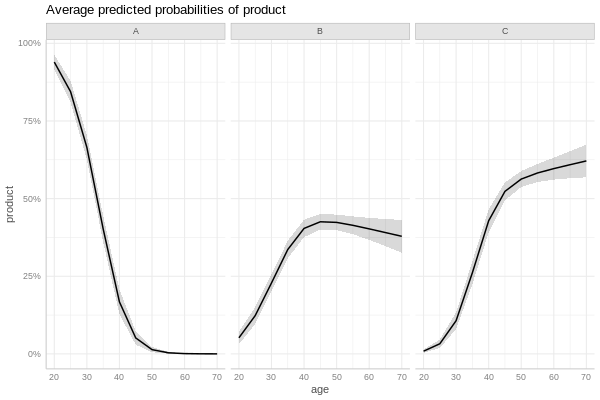

In [ ]:
%%R -w 600 -h 400 -u px
effect<-ggeffects::predict_response(fit.multinom, "age", margin = "empirical")
plot(effect)

In [ ]:
%%R
effect$predicted[2] - effect$predicted[1]

[1] -0.8878722


  plots.



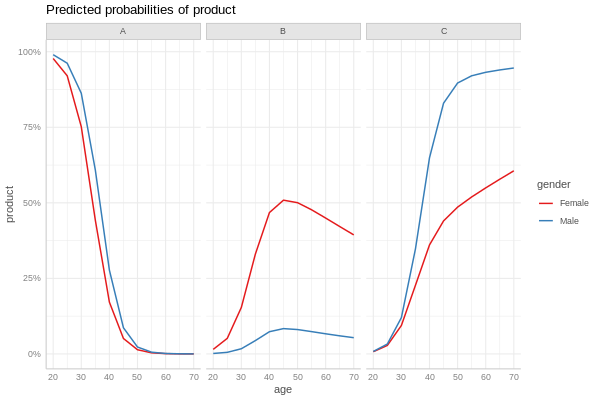

In [ ]:
%%R -w 600 -h 400 -u px
#| fig.height: 5
was.wfe <- predict_response(fit.multinom, terms = c("age", "gender"))
plot(was.wfe, facets = TRUE)

### Cross-validation

In [26]:
%%R
# Set a seed for reproducibility
set.seed(123)
mf$product <- relevel(mf$product, ref = "A")

# Define the number of folds for cross-validation
k <- 10
folds <- sample(rep(1:k, length.out = nrow(mf)))

# Initialize a vector to store accuracy
accuracy <- numeric(k)

# Perform k-fold cross-validation
for(i in 1:k) {
  # Split the data into training and test sets
  train_data <- mf[folds != i, ]
  test_data <- mf[folds == i, ]

  # Fit the multinomial logistic regression model
  model <- multinom(product ~ ., data = train_data)

  # Make predictions on the test set
  predictions <- predict(model, newdata = test_data)

  # Calculate accuracy
  accuracy[i] <- mean(predictions == test_data$product)
}

# Calculate and print the average accuracy across all folds
average_accuracy <- mean(accuracy)
cat("Average Accuracy from Cross-Validation: ", average_accuracy, "\n")

# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 845.553727
iter  20 value 667.198403
final  value 667.143901 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 847.246088
iter  20 value 668.901238
final  value 668.810030 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 853.565387
iter  20 value 668.226170
final  value 668.169797 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 867.663926
iter  20 value 658.594898
final  value 658.533703 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 857.381406
iter  20 value 674.130530
final  value 674.076607 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 828.673560
iter  20 value 653.453615
final  value 653.401842 
converged
# weights:  21 (12 variable)
initial  value 1431.491812 
iter  10 value 841.848425
iter  20 value 667.021539
final  value 666.943761 
co

### Prediction at Test Data



The `predict()` function for logistic models returns the default predictions of log-odds, which are probabilities on the logit scale. When type = `response`, the function provides the predicted probabilities.


In [39]:
%%R
test$Pred.Class<-predict(fit.multinom, test, type = "class")


#### Overall Auccuracy

In [ ]:
%%R
# Calculate accuracy
test.accuracy <- mean(test$Pred.Class == test$product)
cat("Test Accuracy: ", test.accuracy , "\n")

#### Confusion Matrix

In [41]:
%%R
# Create a confusion matrix
conf.matrix.test <- table(Predicted = test$Pred.Class, Actual = test$product)
conf.matrix.test

         Actual
Predicted   A   B   C
        A 119  25  19
        B  20 101  20
        C  10  12 112


#### In-class Accuracy or Per-class Accuracy





In [40]:
%%R
# Calculate in-class accuracy
in_class_accuracy.test <- diag(conf.matrix.test) / colSums(conf.matrix.test)

# Display in-class accuracy for each class
cat("In-Class Accuracy for each class:\n")
print(round(in_class_accuracy.test * 100, 2))

In-Class Accuracy for each class:
    A     B     C 
79.87 73.19 74.17 


## Summary and Conclusion

Understanding ordinal regression and how to implement it in R can provide valuable insights into the relationships between predictor variables and ordinal response variables. This can lead to a deeper understanding of the factors influencing the outcome of interest. It's important to approach ordinal regression carefully, taking into consideration the specific data and research question.

## References

1. [Ordinal logistic regression](https://www.bookdown.org/rwnahhas/RMPH/blr-ordinal.html)

2. [ORDINAL LOGISTIC REGRESSION | R DATA ANALYSIS EXAMPLES](https://stats.oarc.ucla.edu/r/dae/ordinal-logistic-regression/)

3. [How to Perform Ordinal Logistic Regression in R](https://www.r-bloggers.com/2019/06/how-to-perform-ordinal-logistic-regression-in-r/)

4. [Chapter 12 Ordinal Logistic Regression](https://bookdown.org/chua/ber642_advanced_regression/ordinal-logistic-regression.html)

5. [Handbook of Regression Modeling in People Analytics:](https://peopleanalytics-regression-book.org/)